In [9]:
!wget https://data.deepai.org/PascalVOC2012.zip

--2025-01-27 19:11:16--  https://data.deepai.org/PascalVOC2012.zip
Resolving data.deepai.org (data.deepai.org)... 169.150.247.33, 2400:52e0:1e00::1049:1
Connecting to data.deepai.org (data.deepai.org)|169.150.247.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3899239928 (3.6G) [application/zip]
Saving to: ‘PascalVOC2012.zip’

PascalVOC2012.zip   100%[===================>]   3.63G  5.22MB/s    in 12m 23s 

2025-01-27 19:23:39 (5.01 MB/s) - ‘PascalVOC2012.zip’ saved [3899239928/3899239928]



In [10]:
!unzip PascalVOC2012.zip

Archive:  PascalVOC2012.zip
  inflating: VOC2012/Annotations/2007_000027.xml  
  inflating: VOC2012/Annotations/2007_000032.xml  
  inflating: VOC2012/Annotations/2007_000033.xml  
  inflating: VOC2012/Annotations/2007_000039.xml  
  inflating: VOC2012/Annotations/2007_000042.xml  
  inflating: VOC2012/Annotations/2007_000061.xml  
  inflating: VOC2012/Annotations/2007_000063.xml  
  inflating: VOC2012/Annotations/2007_000068.xml  
  inflating: VOC2012/Annotations/2007_000121.xml  
  inflating: VOC2012/Annotations/2007_000123.xml  
  inflating: VOC2012/Annotations/2007_000129.xml  
  inflating: VOC2012/Annotations/2007_000170.xml  
  inflating: VOC2012/Annotations/2007_000175.xml  
  inflating: VOC2012/Annotations/2007_000187.xml  
  inflating: VOC2012/Annotations/2007_000241.xml  
  inflating: VOC2012/Annotations/2007_000243.xml  
  inflating: VOC2012/Annotations/2007_000250.xml  
  inflating: VOC2012/Annotations/2007_000256.xml  
  inflating: VOC2012/Annotations/2007_000272.xml  
  i

In [11]:
!mv voc2012 VOCdevkit

In [12]:
!pip install segmentation-models-pytorch torch torchvision opencv-python augmentations

Note: you may need to restart the kernel to use updated packages.


In [13]:
%matplotlib inline
import random

import cv2
import torch
import torchvision
import numpy as np
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
from matplotlib import pyplot as plt
from PIL import Image
from torchvision.datasets import VOCSegmentation

In [14]:
torch.cuda.is_available()

True

## Подготовка данных

In [29]:
DATA_ROOT = "."
VOC_YEAR = "2012"
LABELS = ["background", "aeroplane", "bicycle", "bird", "boat", "bottle",
          "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse",
          "motorbike", "person", "potted_plant", "sheep", "sofa", "train", "tv/monitor"]

NUM_CLASSES = len(LABELS)
print("Number of classes:", NUM_CLASSES)

Number of classes: 21


In [30]:
{idx: label for idx, label in enumerate(LABELS)}

{0: 'background',
 1: 'aeroplane',
 2: 'bicycle',
 3: 'bird',
 4: 'boat',
 5: 'bottle',
 6: 'bus',
 7: 'car',
 8: 'cat',
 9: 'chair',
 10: 'cow',
 11: 'diningtable',
 12: 'dog',
 13: 'horse',
 14: 'motorbike',
 15: 'person',
 16: 'potted_plant',
 17: 'sheep',
 18: 'sofa',
 19: 'train',
 20: 'tv/monitor'}

Mask values: {0, 3, 255}


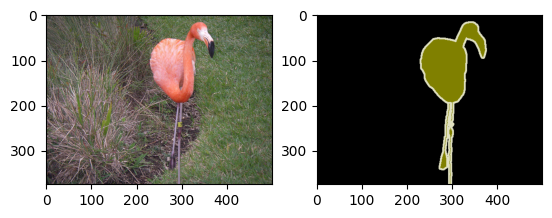

In [31]:
valset_raw = VOCSegmentation(DATA_ROOT, VOC_YEAR, "val", download=False)

image, mask = valset_raw[random.randint(0, len(valset_raw) - 1)]
print("Mask values:", set(np.array(mask).flatten().tolist()))

fig, axs = plt.subplots(1, 2)
axs[0].imshow(image)
axs[1].imshow(mask)
plt.show()

In [32]:
import torchvision.transforms as T

class VOCDataset(torch.utils.data.Dataset):
    """Обертка для стандартного класса, которая форматирует данные."""
    def __init__(self, root, year, download=False, transforms=None, train=False, train_fraction=0.8):
        """Создать корпус.
        
        Аргументы:
            root: Путь до папки для хранения данных.
            year: 2007 или 2012.
            download: Скачать корпус, если он не найден в папке.
            transforms: преобразование данных, аугментация
            train: Выделить train часть, иначе validation.
            train_fraction: Доля тренировочных примеров.
        """
        self._dataset = torchvision.datasets.VOCSegmentation(root, str(year), "trainval", download=download)
        self.transforms = transforms

        ids = list(range(len(self._dataset)))
        random.seed(0)
        random.shuffle(ids)
        train_size = int(len(ids) * train_fraction)
        self._indices = ids[:train_size] if train else ids[train_size:]
        
    def __len__(self):
        return len(self._indices)
    
    def __getitem__(self, idx):
        image, mask = self._dataset[self._indices[idx]]
        if not isinstance(image, Image.Image):
            image = Image.fromarray(np.asarray(image))
        if not isinstance(mask, Image.Image):
            mask = Image.fromarray(np.asarray(mask))

        # Применяем преобразования
        if self.transforms:
            image, mask = self.transforms(image, mask)

        # Преобразуем маску в тензор отдельно
        mask = T.ToTensor()(mask) * 255  # Масштабируем
        mask = mask.long().squeeze(0)  # Убираем лишний размер

        image = T.ToTensor()(image)
        return image, mask

In [33]:
from torchvision.transforms import functional as F
import random

class RandomHorizontalFlip:
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img, mask):
        if random.random() < self.p:
            img = F.hflip(img)
            mask = F.hflip(mask)
        return img, mask


class RandomRotation:
    def __init__(self, degrees):
        self.degrees = degrees

    def __call__(self, img, mask):
        angle = random.uniform(-self.degrees, self.degrees)
        img = F.rotate(img, angle)
        mask = F.rotate(mask, angle, interpolation=F.InterpolationMode.NEAREST)
        return img, mask


class AddGaussianNoise:
    def __init__(self, mean=0.0, std=0.01):
        self.mean = mean
        self.std = std

    def __call__(self, img, mask):
        np_img = np.array(img, dtype=np.float32) / 255.0
        noise = np.random.normal(self.mean, self.std, np_img.shape).astype(np.float32)
        np_img = np.clip(np_img + noise, 0, 1) * 255.0
        img = Image.fromarray(np_img.astype(np.uint8))
        return img, mask


class Resize:
    def __init__(self, size):
        self.size = size

    def __call__(self, img, mask):
        img = F.resize(img, self.size)
        mask = F.resize(mask, self.size, interpolation=F.InterpolationMode.NEAREST)
        return img, mask


class DualCompose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, mask):
        for t in self.transforms:
            img, mask = t(img, mask)
        return img, mask


train_transforms = DualCompose([
    Resize((256, 256)),
    RandomHorizontalFlip(p=0.5),
    RandomRotation(degrees=15),
    AddGaussianNoise(mean=0.0, std=0.02),
])

val_transforms = DualCompose([
    Resize((256, 256)),
])


In [34]:
from torch.utils.data import DataLoader


train_dataset = VOCDataset(
    root=DATA_ROOT,
    year=2012,
    transforms=train_transforms,
    train=True
)

val_dataset = VOCDataset(
    root=DATA_ROOT,
    year=2012,
    transforms=val_transforms,
    train=False
)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

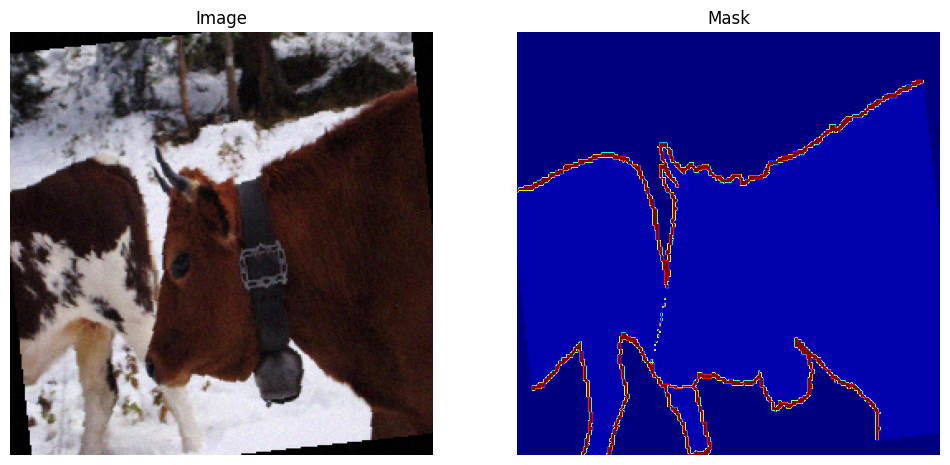

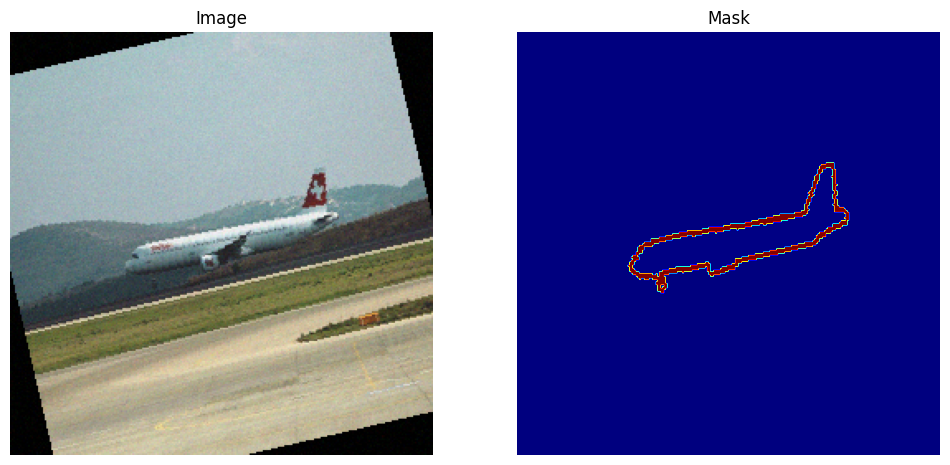

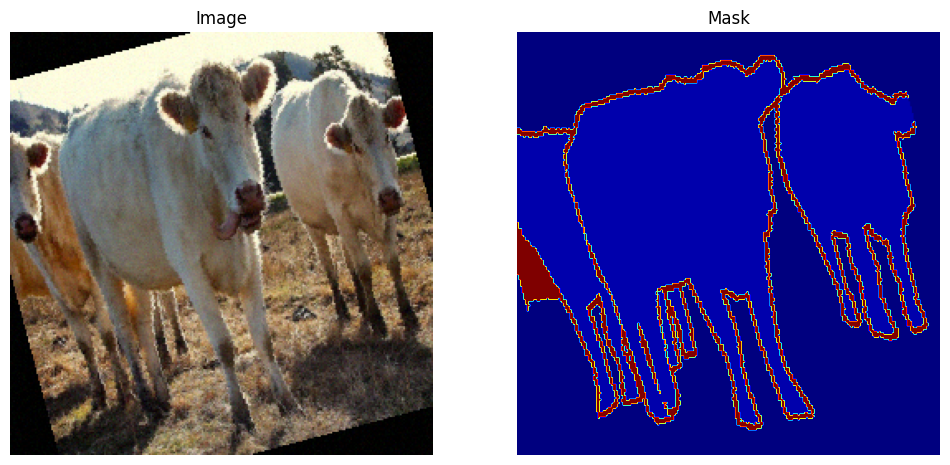

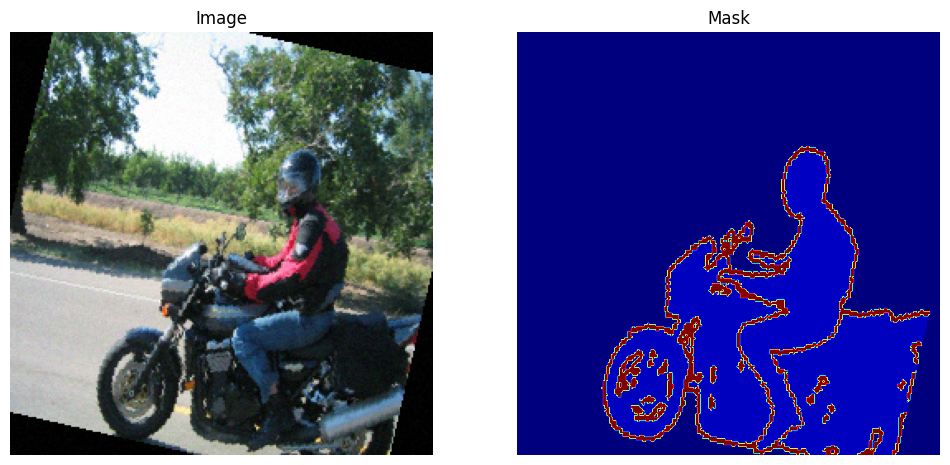

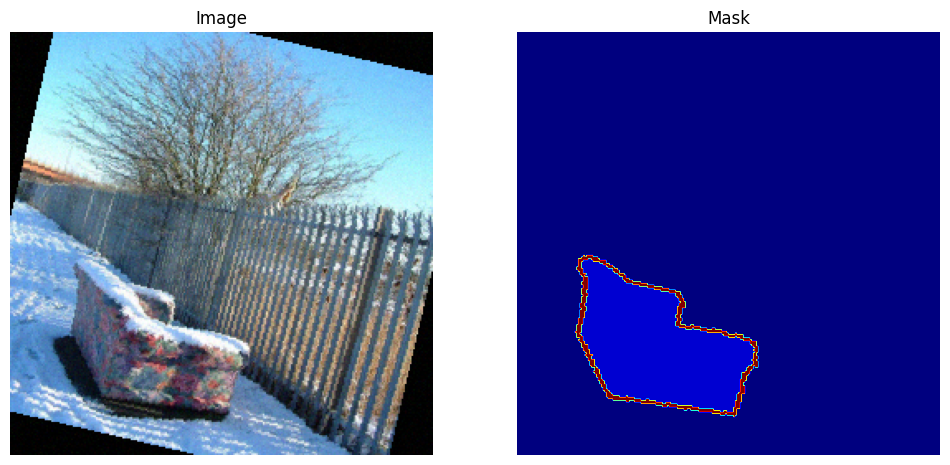

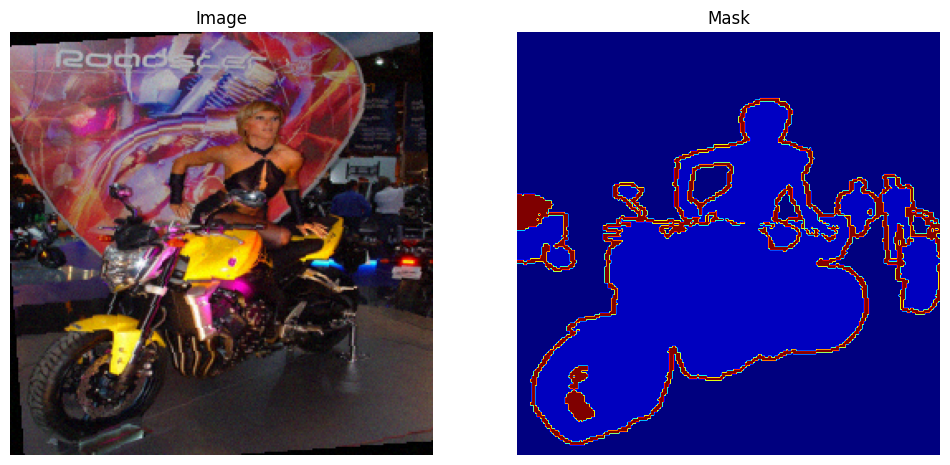

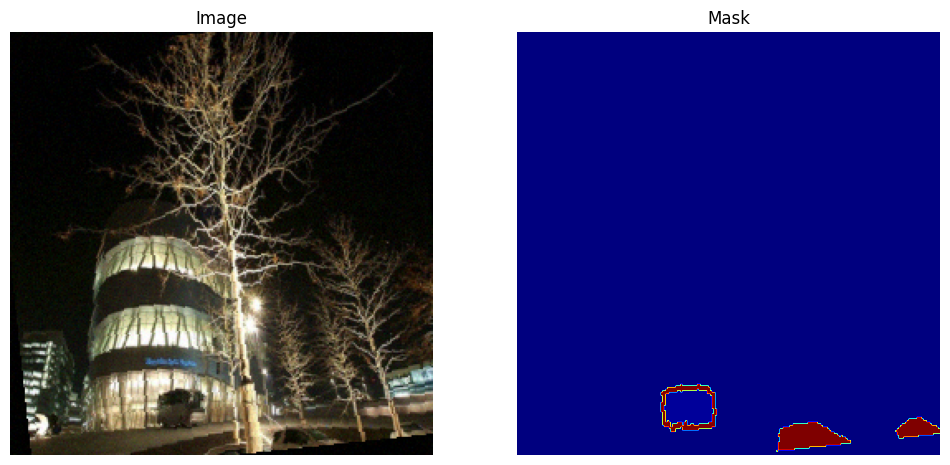

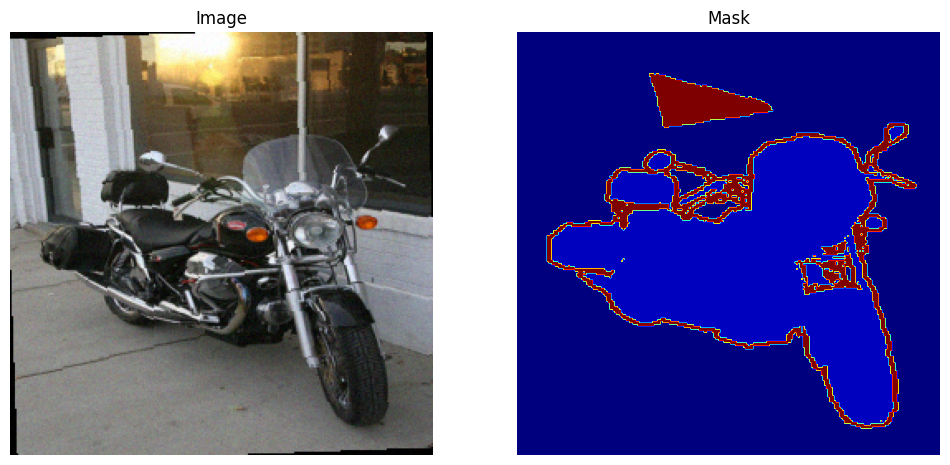

IndexError: index 8 is out of bounds for dimension 0 with size 8

In [35]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

def show_image_and_mask(image, mask):
    to_pil_image = ToPILImage()

    image = image.cpu().clamp(0, 1)
    mask = mask.cpu().to(torch.uint8)

    image_pil = to_pil_image(image)
    mask_pil = to_pil_image(mask)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(image_pil)
    axes[0].set_title("Image")
    axes[0].axis('off')

    axes[1].imshow(mask_pil, cmap='jet')
    axes[1].set_title("Mask")
    axes[1].axis('off')

    plt.show()


for i, (images, masks) in enumerate(train_loader):
    if i == 10
        break
    
    show_image_and_mask(images[i], masks[i])


## Обучим модель deeplabv3

In [36]:
from torchvision.models.segmentation import deeplabv3_resnet50
from torch.optim import Adam

device = torch.device("cuda")

model = deeplabv3_resnet50(pretrained=True)
model.classifier[4] = torch.nn.Conv2d(256, 21, kernel_size=1)  # PASCAL VOC has 21 classes
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss(ignore_index=255)
optimizer = Adam(model.parameters(), lr=1e-4)

In [37]:
from tqdm import tqdm

In [38]:
num_epochs = 10
train_losses, val_losses, miou_scores = [], [], []

def mean_iou(pred, target, num_classes=21):
    iou = []
    pred = torch.argmax(pred, dim=1)
    for cls in range(num_classes):
        pred_cls = pred == cls
        target_cls = target == cls
        intersection = (pred_cls & target_cls).sum().item()
        union = (pred_cls | target_cls).sum().item()
        if union == 0:
            iou.append(float('nan'))
        else:
            iou.append(intersection / union)
    return np.nanmean(iou)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for imgs, masks in tqdm(train_loader):
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0
    miou = 0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)['out']
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            miou += mean_iou(outputs, masks)

    val_losses.append(val_loss / len(val_loader))
    miou_scores.append(miou / len(val_loader))

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, mIoU: {miou_scores[-1]:.4f}")


100%|██████████| 292/292 [01:55<00:00,  2.53it/s]


Epoch 1/10, Train Loss: 1.3385, Val Loss: 0.7723, mIoU: 0.2721


100%|██████████| 292/292 [01:56<00:00,  2.50it/s]


Epoch 2/10, Train Loss: 0.6491, Val Loss: 0.5062, mIoU: 0.3533


100%|██████████| 292/292 [01:55<00:00,  2.52it/s]


Epoch 3/10, Train Loss: 0.4670, Val Loss: 0.4167, mIoU: 0.3629


100%|██████████| 292/292 [01:56<00:00,  2.51it/s]


Epoch 4/10, Train Loss: 0.3797, Val Loss: 0.3422, mIoU: 0.4124


100%|██████████| 292/292 [01:56<00:00,  2.51it/s]


Epoch 5/10, Train Loss: 0.3208, Val Loss: 0.3513, mIoU: 0.4064


100%|██████████| 292/292 [01:55<00:00,  2.52it/s]


Epoch 6/10, Train Loss: 0.2612, Val Loss: 0.3377, mIoU: 0.4167


100%|██████████| 292/292 [01:56<00:00,  2.50it/s]


Epoch 7/10, Train Loss: 0.2615, Val Loss: 0.4060, mIoU: 0.3926


100%|██████████| 292/292 [01:56<00:00,  2.51it/s]


Epoch 8/10, Train Loss: 0.2301, Val Loss: 0.3355, mIoU: 0.4149


100%|██████████| 292/292 [01:56<00:00,  2.51it/s]


Epoch 9/10, Train Loss: 0.2140, Val Loss: 0.3448, mIoU: 0.4186


100%|██████████| 292/292 [01:56<00:00,  2.51it/s]


Epoch 10/10, Train Loss: 0.1906, Val Loss: 0.3370, mIoU: 0.4143


## Визуализация изменения loss и mean iou

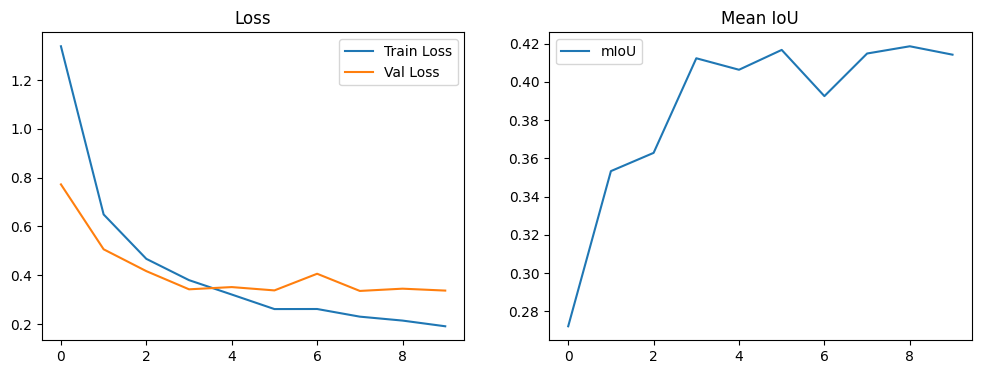

In [39]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(miou_scores, label='mIoU')
plt.legend()
plt.title('Mean IoU')

plt.show()

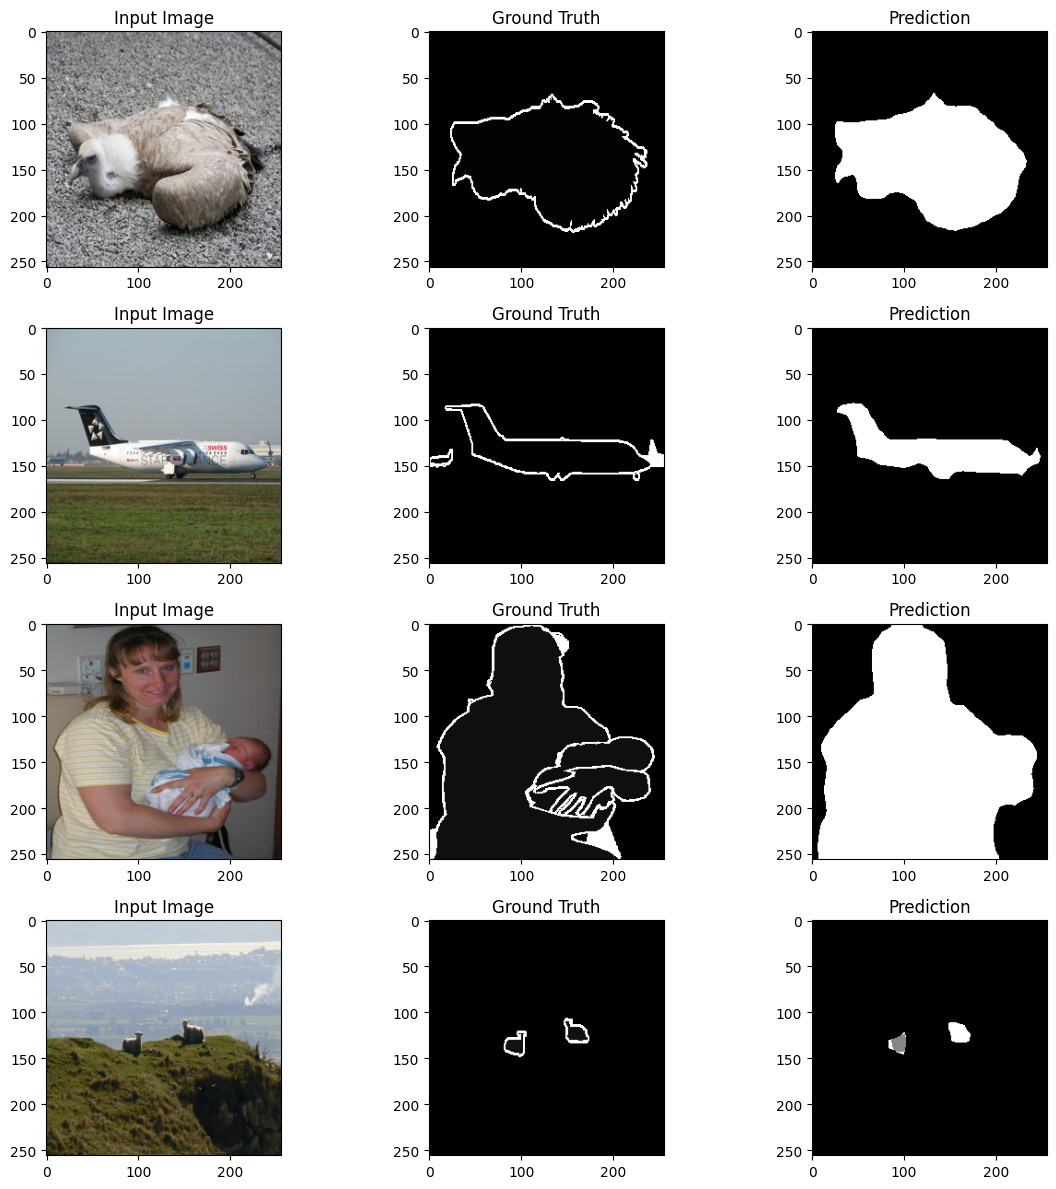

In [40]:
def visualize_predictions(model, loader):
    model.eval()
    imgs, masks = next(iter(loader))
    imgs = imgs.to("cuda")
    with torch.no_grad():
        outputs = model(imgs)['out']
    preds = torch.argmax(outputs, dim=1).cpu()

    fig, axes = plt.subplots(4, 3, figsize=(12, 12))
    for i in range(4):
        axes[i, 0].imshow(imgs[i].cpu().permute(1, 2, 0))
        axes[i, 1].imshow(masks[i].cpu(), cmap='gray')
        axes[i, 2].imshow(preds[i], cmap='gray')
        axes[i, 0].set_title('Input Image')
        axes[i, 1].set_title('Ground Truth')
        axes[i, 2].set_title('Prediction')
    plt.tight_layout()
    plt.show()

visualize_predictions(model, val_loader)